In [8]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.backend import clear_session
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from tqdm import tqdm
from numpy.random import seed
import tensorflow as tf
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import datetime
import os

In [9]:
#Data Parameters
num_of_classes = 54
data_shape = (119,1)

#MLP Parameters
times_to_run = 10 #Number of times to run MLP model
mlp_epochs = 40
valid_split = 0.20

#Random Seeds
selection_seed = 150
seed_multiplier = 1000000

In [10]:
path = "./data/00_sorted.csv"
train_df = pd.read_csv(path,header=0)
print(train_df.shape)
a = train_df.mean()
print(a["WAP004"])
for i in train_df.columns[:520]:
    if a[i]==-110:
        del train_df[i]
print(train_df.shape)
train_df["REF"] = pd.factorize(train_df["REF"])[0].astype(int)#将标签映射到顺序数字上
labels = train_df.REF.values
features = train_df.drop(columns=['TIMESTAMP','PHONEID','USERID','RELATIVEPOSITION',
                                'SPACEID','BUILDINGID','FLOOR','LATITUDE','LONGITUDE',
                                'BF','REF']).values
input_shape = features.shape[1:]
features,labels,features.shape

(1059, 531)
-110.0
(1059, 130)


(array([[-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        ...,
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110]], dtype=int64),
 array([ 0,  0,  0, ..., 53, 53, 53]),
 (1059, 119))

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2,
                                                    random_state= selection_seed,
                                                    #random_state：可以理解为随机数种子，主要是为了复现结果而设置
                                                    stratify=labels)#stratify保证测试集中，所有类别的齐全
X_train,X_train.shape,Y_train,Y_train.shape

(array([[-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        ...,
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110]], dtype=int64),
 (847, 119),
 array([ 3, 13, 45, 14,  6, 22, 15, 10,  8, 29, 48, 26,  9, 36,  0, 19, 13,
         5, 20, 44, 18, 44, 34, 17, 19,  4, 11, 45, 13, 51, 26, 22, 13, 53,
        27, 32, 44, 25, 50, 46, 28, 19,  5, 32, 45, 49, 16,  8, 24,  9, 46,
        39, 51, 13, 15, 42, 14, 34, 17, 12, 40, 42,  7,  4, 15, 40, 24, 37,
        28,  6, 21, 37, 35, 16, 27, 27, 31, 50, 37, 52, 24, 41, 21, 42, 38,
        35, 53, 31, 46, 29, 29, 47,  5, 26, 18, 12, 35, 22, 17, 20, 20, 23,
         1, 41, 33, 42, 17,  5, 50, 25, 25, 13, 21, 21, 24, 17, 27, 12,  3,
        18, 12, 24, 14, 38, 21, 45, 25, 25, 13,  8, 25, 25, 27, 23, 39,  7,
        14, 50, 33,  4, 19, 33, 28, 46, 47, 2

In [12]:
X_train, Y_train = shuffle(X_train, Y_train)

#将类别向量映射为二值类别矩阵, 用于应用到以categorical_crossentropy为目标函数的模型中.
#to_categorical和pd.get_dummies推荐前者，后者原理更复杂
Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)
scaler = StandardScaler()  #from sklearn.preprocessing import StandardScaler
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)
X_train_transformed.shape

(847, 119)

In [13]:
all_test_loss =[]
all_test_acc = []
history = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)#操作级
    tf.random.set_seed(i*seed_multiplier)#图级
    inp = Input(shape=input_shape,name='ap_features')
    x = Dense(1024,activation=LeakyReLU(alpha=0))(inp)
    x = Dropout(0.1)(x)
    x = Dense(512,activation=LeakyReLU(alpha=0))(x)
    x = Dropout(0.1)(x)
    x = Dense(256,activation=LeakyReLU(alpha=0))(x)
    x = Dropout(0.1)(x)
    x = Dense(128,activation=LeakyReLU(alpha=0))(x)
    output = Dense(54,activation='softmax')(x)
    model = Model(inp,output)

    model.compile(optimizer=Adam(0.0002, 0.5),#learning rate, the exponential decay rate for the 1st moment estimates
                                              # 学习率      , 一阶矩估计的指数衰减率
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=32,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)
    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)
    print("#{} Test acc:".format(i), test_acc)

    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    del(model)
    clear_session()

C:\Users\xfp\AppData\Local\Temp\ipykernel_14124\3108810693.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/10 [00:00<?, ?it/s]

#0 Test acc: 0.7358490824699402
#1 Test acc: 0.7075471878051758
#2 Test acc: 0.7264150977134705
#3 Test acc: 0.7075471878051758
#4 Test acc: 0.7075471878051758
#5 Test acc: 0.7452830076217651
#6 Test acc: 0.7264150977134705
#7 Test acc: 0.6886792182922363
#8 Test acc: 0.7028301954269409
#9 Test acc: 0.7264150977134705


(1.1486209988594056, 0.7174528360366821)

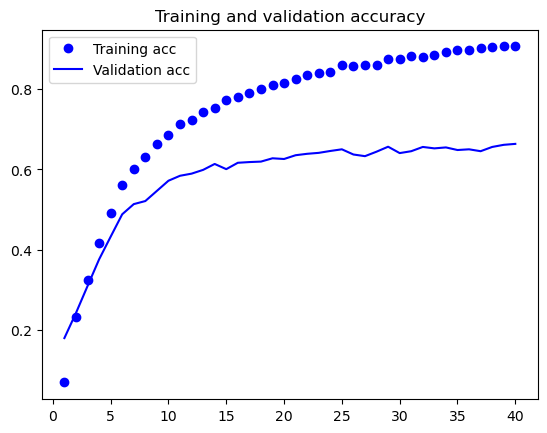

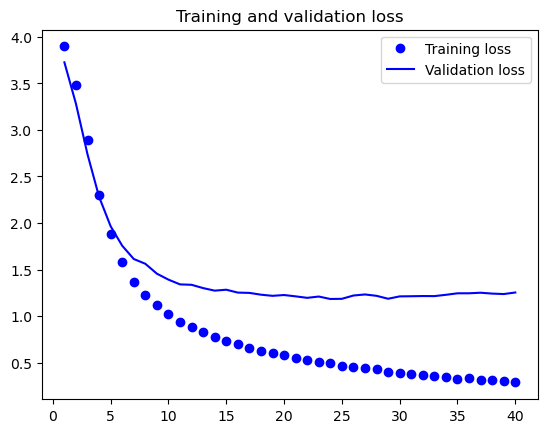

In [14]:
trainacc = []
trainloss = []
valacc = []
valloss = []
for i in range (len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

now = datetime.datetime.now()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()#作用是加上图例，很有必要
plt.savefig("./real/real_TRandVAL_acc.png")
plt.figure()#创建新图
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("./real/real_TRandVAL_loss.png")
test_loss = np.mean(all_test_loss, axis=0)
test_acc = np.mean(all_test_acc, axis=0)
test_loss,test_acc

In [18]:
from sklearn import neighbors

knn1 = neighbors.KNeighborsClassifier(n_neighbors = 1)
# knn1.fit(new_x_train,y_train)
knn1.fit(X_train,Y_train)
acc = knn1.score(X_test,Y_test) 
print('the accurancy is: %.4f'  %acc)

the accurancy is: 0.7783


In [19]:
AccMean = np.mean(all_test_acc)
LossMean = np.mean(all_test_loss)
AccStd = np.std(all_test_acc)
LossStd = np.std(all_test_loss)

lines  = list()
# lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean: {}".format(AccMean))
lines.append("Loss mean: {}".format(LossMean))
lines.append("Accuracy STD: {}".format(AccStd))
lines.append("Loss STD: {} \n".format(LossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss[np.argmax(all_test_acc)]))
lines.append("acc of the knn: {}".format(acc))
file_dir = ("./real/test.txt")
with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write('%s\n' % items)